In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv


In [2]:
cd /kaggle/input/competitive-data-science-predict-future-sales/

/kaggle/input/competitive-data-science-predict-future-sales


In [3]:
sales_train= pd.read_csv("sales_train.csv")
item_categories=pd.read_csv("item_categories.csv")
items= pd.read_csv("items.csv")
shops= pd.read_csv("shops.csv")
test= pd.read_csv("test.csv")
submission=pd.read_csv("sample_submission.csv")

In [4]:
test.shape

(214200, 3)

In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## Exploratory Data Analysis（探索的データ解析)

In [6]:
sales_train.shape#(2935849, 6)

(2935849, 6)

次に時系列データに関して、トレンドや季節などの情報がないかを調べる。

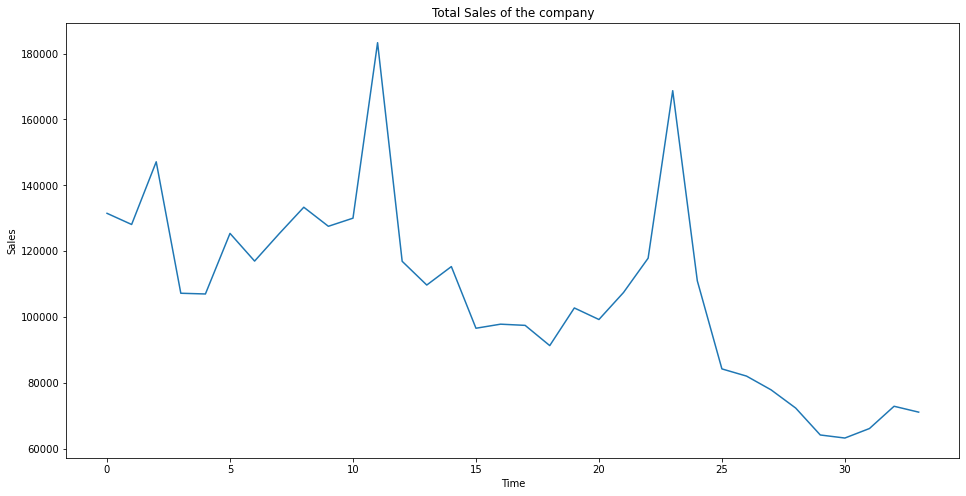

In [7]:
import matplotlib.pyplot as plt
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

上記のグラフより、季節による変動、そしてトレンドなどの影響があることがわかった。  
故にこれらの特徴を元に、機械学習のモデルを選択していく。


## 使用する機械学習アルゴリズム

今回のデータは、特徴量が2つ、データ数が33となっている。特徴量の数が非常に少ないため、モデルは複雑になる。線形回帰ベースのモデルでは、特徴量エンジニアリングで事前処理を行わないと、複雑なモデルを表現することができず、今回の場合は、元の特徴量が2つということなので、不適である。そこで線形ではなく、複雑なモデルにも対応できるSVRカーネルを用いる。  
今回のように、時系列データの場合、訓練データ外への外挿できない決定木モデルは不適とされている。また、上で見たように、これらのデータセットはトレンドや季節の影響を受ける。自己相関関係がある場合には、深層学習のLSTMアルゴリズムを用いるのが適切であると判断した。  
故に、今回は時系列データへのディープラーニングベースのモデル(LSTM)を用いて、売り上げ予測を行う。  
  
### 使用するアルゴリズム   
ディープラーニングベースのモデル(LSTM)



 ## LSTM

In [8]:
sales_train1=sales_train.drop("item_price", axis=1)

In [9]:
dataset1=pd.pivot_table(sales_train1, index=['shop_id','item_id'], columns='date_block_num',aggfunc=sum)#この集計は平均値を出しているのか、それとも合計の値を出しているのか大変重要
dataset1=dataset1.fillna(0)
#aggfunc=sum

In [10]:

dataset1.head()

item_cnt_day                                                \
date_block_num            0     1    2    3    4    5    6    7    8    9    
shop_id item_id                                                              
0       30               0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31               0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32               6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33               3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35               1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 ...                                                    
date_block_num   ...   24   25   26   27   28   29   30   31   32   33  
shop_id item_id  ...                                                    
0       30       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [11]:
sales_train2=sales_train.drop("item_cnt_day", axis=1)

In [12]:
dataset2=pd.pivot_table(sales_train2, index=['shop_id','item_id'], columns='date_block_num')#この集計は平均値を出している。
dataset2=dataset2.fillna(0)
dataset2.head()

item_price                                                 \
date_block_num          0      1    2    3    4    5    6    7    8    9    
shop_id item_id                                                             
0       30             0.0  265.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31             0.0  434.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32           221.0  221.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33           347.0  347.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35           247.0  247.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 ...                                                    
date_block_num   ...   24   25   26   27   28   29   30   31   32   33  
shop_id item_id  ...                                                    
0       30       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [13]:
dataset1 = pd.merge(test, dataset1, on=['item_id', 'shop_id'], how='left')
dataset1=dataset1.fillna(0)
dataset1.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
dataset2 = pd.merge(test, dataset2, on=['item_id', 'shop_id'], how='left')
dataset2=dataset2.fillna(0)
dataset2.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,ID,shop_id,item_id,"(item_price, 0)","(item_price, 1)","(item_price, 2)","(item_price, 3)","(item_price, 4)","(item_price, 5)","(item_price, 6)",...,"(item_price, 24)","(item_price, 25)","(item_price, 26)","(item_price, 27)","(item_price, 28)","(item_price, 29)","(item_price, 30)","(item_price, 31)","(item_price, 32)","(item_price, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1999.0,0.0,0.0,0.0,1299.0,1499.0,1499.0,999.166667,749.5,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,899.0,599.0,0.0,599.000000,999.0,1199.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599.000000,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [15]:
dataset1 = dataset1.drop(['shop_id', 'item_id', 'ID'], axis=1)
dataset1.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
dataset2 = dataset2.drop(['shop_id', 'item_id', 'ID'], axis=1)
dataset2.head()

,"(item_price, 0)","(item_price, 1)","(item_price, 2)","(item_price, 3)","(item_price, 4)","(item_price, 5)","(item_price, 6)","(item_price, 7)","(item_price, 8)","(item_price, 9)",...,"(item_price, 24)","(item_price, 25)","(item_price, 26)","(item_price, 27)","(item_price, 28)","(item_price, 29)","(item_price, 30)","(item_price, 31)","(item_price, 32)","(item_price, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1999.0,0.0,0.0,0.0,1299.0,1499.0,1499.0,999.166667,749.5,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,899.0,599.0,0.0,599.000000,999.0,1199.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,599.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


dataset1には、ショップ別の各々のアイテムについての1ヶ月あたりの売上数  
dataset2には、ショップ別の各々のアイテムについての1ヶ月あたりの金額の平均値の推移

In [17]:
X1_train = np.expand_dims(dataset1.values[:, :-1], axis=2)
y1_train = dataset1.values[:, -1:]
X2_train = np.expand_dims(dataset2.values[:, :-1], axis=2)

X1_test = np.expand_dims(dataset1.values[:, 1:], axis=2)
X2_train = np.expand_dims(dataset2.values[:, 1:], axis=2)

In [18]:
#X_train=np.stack([X1_train, X2_train],2).reshape(214200, 33, 2)

LSTMでは、dataset1だけを用いて、予測を行う。

In [19]:
X1_train = np.expand_dims(dataset1.values[:, :-1], axis=2)
y1_train = dataset1.values[:, -1:]
X2_train = np.expand_dims(dataset2.values[:, :-1], axis=2)

X1_test = np.expand_dims(dataset1.values[:, 1:], axis=2)
X2_train = np.expand_dims(dataset2.values[:, 1:], axis=2)

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


Using TensorFlow backend.


In [21]:
import matplotlib.pyplot as plt
from keras import optimizers

In [48]:
lr = 0.0001
model = Sequential()
model = Sequential()
model.add(LSTM(10, input_shape=(33, 1), return_sequences=True))
model.add(LSTM(6, activation='relu', return_sequences=True))
model.add(LSTM(1, activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1))
adam = optimizers.Adam(lr)
model.compile(loss='mse',
              optimizer=adam,
              metrics=['mean_squared_error'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 33, 10)            480       
_________________________________________________________________
lstm_11 (LSTM)               (None, 33, 6)             408       
_________________________________________________________________
lstm_12 (LSTM)               (None, 1)                 32        
_________________________________________________________________
dense_10 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
____________________________________________________

### 外れ値の考慮


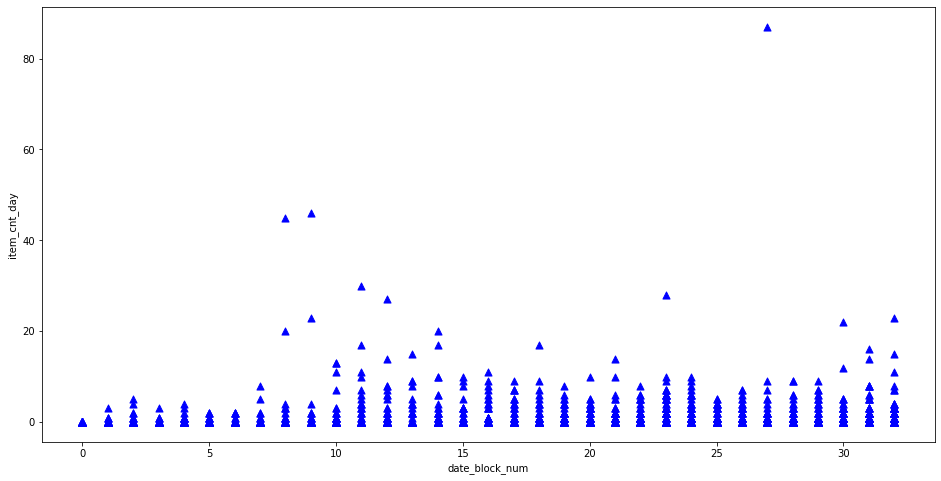

In [23]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1,1,1)


j=np.array(range(33))
ax.set_xlabel('date_block_num')
ax.set_ylabel('item_cnt_day')

fig.show()

for i in range (100):
    ax.scatter(j,X1_train[i],c='blue',marker='^', s=50)
    


In [24]:
# 99%点と100%点を表示させる
q99, q100= np.percentile(X1_train, [99 ,100])
print("99%点",q99)
print("100%点",q100)

99%点 4.0
100%点 1305.0


In [25]:
# 99%点と100%点を表示させる
q0, q1= np.percentile(X1_train, [0 ,1])
print("0%点",q0)
print("1%点",q1)

0%点 -4.0
1%点 0.0


上の結果から、数点の外れ値が存在することがわかった。ここでは、0以下の数は全て0に、20以上の値を外れ値とし全て99%点で置き換える。

In [26]:
X1_train.shape

(214200, 33, 1)

In [27]:
X1_train[X1_train>=20.0]=20.0
X1_train[X1_train<0.0]=0.0
y1_train[y1_train>=20.0]=20.0
y1_train[y1_train<0.0]=0.0
X1_test[X1_test>=20.0]=20.0
X1_test[X1_test<0.0]=0.0

In [28]:
from sklearn import preprocessing

In [29]:
preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [30]:
sscaler = preprocessing.StandardScaler() # インスタンスの作成

sscaler.fit(X1_train.reshape(214200, 33))           # 訓練データの平均と分散を計算
X1_train2=sscaler.transform(X1_train.reshape(214200, 33))
X1_test2=sscaler.transform(X1_test.reshape(214200, 33))#訓練データの変換をテストデータに用いる

In [32]:
X1_train2=X1_train2.reshape(214200, 33,1)
X1_test2=X1_test2.reshape(214200, 33,1)

In [49]:
X1_train.shape

(214200, 33, 1)

In [50]:
history = model.fit(X1_train, y1_train, batch_size=3600, epochs=10)

Epoch 1/10
214200/214200 [==============================] - 8s 36us/step - loss: 1.2519 - mean_squared_error: 1.2519
Epoch 2/10
214200/214200 [==============================] - 7s 31us/step - loss: 1.2487 - mean_squared_error: 1.2487
Epoch 3/10
214200/214200 [==============================] - 7s 31us/step - loss: 1.2458 - mean_squared_error: 1.2458
Epoch 4/10
214200/214200 [==============================] - 7s 32us/step - loss: 1.2431 - mean_squared_error: 1.2431
Epoch 5/10
214200/214200 [==============================] - 7s 33us/step - loss: 1.2404 - mean_squared_error: 1.2404
Epoch 6/10
214200/214200 [==============================] - 7s 34us/step - loss: 1.2378 - mean_squared_error: 1.2378
Epoch 7/10
214200/214200 [==============================] - 8s 36us/step - loss: 1.2354 - mean_squared_error: 1.2354
Epoch 8/10
214200/214200 [==============================] - 7s 33us/step - loss: 1.2330 - mean_squared_error: 1.2330
Epoch 9/10
214200/214200 [==============================] - 7s 3

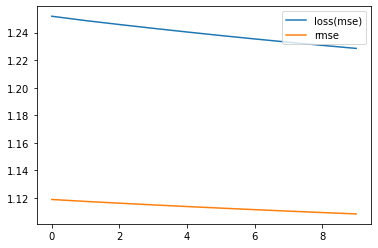

In [51]:
plt.plot(history.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(history.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

時系列データの長さが33となっている。しかし、LSTMの場合、過去のデータの影響も受け続けることになるので、データの長さが長いほどいいとは限らない。今度は、データセットの数をちょうど一年を表す12に減らしてLSTMを適用してみる。


In [52]:
X2_train=X1_train[:,-12:,]
y2_train=y1_train[:,-12:,]
X2_test=X1_train[:,-12:,]

In [53]:
X2_train.shape

(214200, 12, 1)

In [54]:
lr = 0.0001
model2 = Sequential()
model2 = Sequential()
model2.add(LSTM(10, input_shape=(12, 1), return_sequences=True))
model2.add(LSTM(6, activation='relu', return_sequences=True))
model2.add(LSTM(1, activation='relu'))
model2.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model2.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
model2.add(Dense(1))
adam = optimizers.Adam(lr)
model2.compile(loss='mse',
              optimizer=adam,
              metrics=['mean_squared_error'])
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 12, 10)            480       
_________________________________________________________________
lstm_14 (LSTM)               (None, 12, 6)             408       
_________________________________________________________________
lstm_15 (LSTM)               (None, 1)                 32        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
___________________________________________________

In [55]:
history1 = model2.fit(X2_train, y2_train, batch_size=1200, epochs=10,)

Epoch 1/10
214200/214200 [==============================] - 11s 49us/step - loss: 1.2396 - mean_squared_error: 1.2396
Epoch 2/10
214200/214200 [==============================] - 8s 38us/step - loss: 1.2118 - mean_squared_error: 1.2118
Epoch 3/10
214200/214200 [==============================] - 8s 38us/step - loss: 1.1769 - mean_squared_error: 1.1769
Epoch 4/10
214200/214200 [==============================] - 8s 38us/step - loss: 1.1232 - mean_squared_error: 1.1232
Epoch 5/10
214200/214200 [==============================] - 8s 39us/step - loss: 1.0647 - mean_squared_error: 1.0647
Epoch 6/10
214200/214200 [==============================] - 8s 38us/step - loss: 1.0033 - mean_squared_error: 1.0033
Epoch 7/10
214200/214200 [==============================] - 9s 42us/step - loss: 0.9825 - mean_squared_error: 0.9825
Epoch 8/10
214200/214200 [==============================] - 9s 41us/step - loss: 0.9720 - mean_squared_error: 0.9720
Epoch 9/10
214200/214200 [==============================] - 8s 

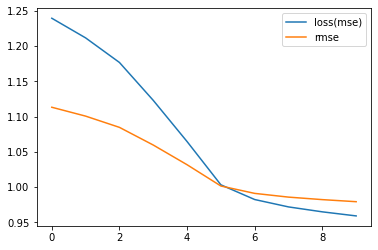

In [56]:
plt.plot(history1.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(history1.history['mean_squared_error']), label= 'rmse')
plt.legend(loc=1)

先ほどの結果と見比べると、非常に正確性が上がったことがわかる。ただし、複雑なモデルに対応しすぎると、過学習の恐れもある。そのためには、本来ならバリデーションデータを作成し、テストデータの性能を比較するのがいいだろう。

In [57]:
LSTM_prediction = model2.predict(X2_test)

In [60]:
LSTM_prediction

array([[0.42650083],
       [0.18794239],
       [0.33308414],
       ...,
       [0.22141424],
       [0.18794239],
       [0.18794239]], dtype=float32)

In [63]:
submission = pd.DataFrame({'ID': test['ID'], 'item_cnt_month': LSTM_prediction.ravel()})
#submission.to_csv('submission.csv',index=False)

In [72]:
cd ../../working

/kaggle/working


In [73]:
submission.to_csv('submission.csv',index=False)